## This notebook is to show the forward model in action

#### To see the kernel learning method, look in the models/notebooks folder.

In [1]:
a = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/gratings_intensity_modulations_nm_resolution.npy')
wl = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/gratings_wavelengths_nm_resolution.npy')

NameError: name 'np' is not defined

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys

main_dir = os.path.dirname(os.path.abspath('../'))
sys.path.insert(0, main_dir)

from forward.fourier import method, kernel_creator
from models.helper import create_bs_data, load_cube, downsample_signal, normalize
# from forward.cube_sim import *

%load_ext autoreload
%autoreload 2

device = 'cuda:0'

In [3]:
kern = kernel_creator.create_fourier_kernel('full')

In [4]:
kern = torch.nan_to_num(kern)

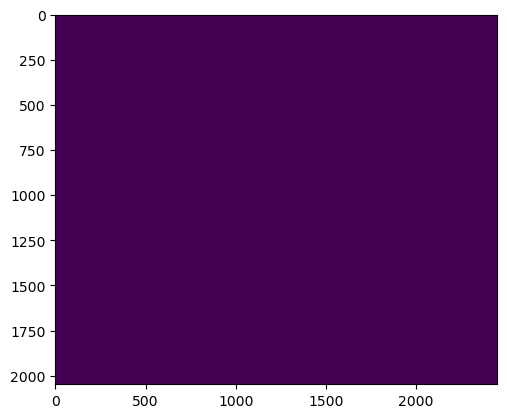

In [5]:
plt.imshow(torch.sum(kern[0],dim = 0).cpu().numpy(),vmax=0.1)

Text(0.5, 1.0, 'mean_kernel in middle left')

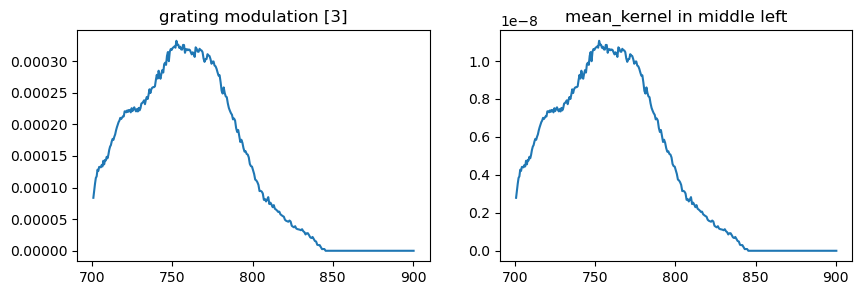

In [6]:
gratings_intensity_modulations = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/gratings_intensity_modulations_nm_resolution.npy')
wavelengths = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/gratings_wavelengths_nm_resolution.npy')

fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(wavelengths,gratings_intensity_modulations[3]); ax[0].set_title('grating modulation [3]')
ax[1].plot(wavelengths,torch.mean(kern[0,:,1000:1100,200:500],dim=(1,2)) ); ax[1].set_title('mean_kernel in middle left')


In [ ]:
 shift_vertical_per_nm =  1.1324938301431489
#vertical dispersion in pixel at 800 nm
shift_vertical_800 = 929.1633879050196
#horizontal dispersion in pixel per nm
shift_horizontal_per_nm = 0.8429029601380736
#horizontal dispersion in pixel at 800 nm
shift_horizontal_800 = 683.6675760385812


#minor vertical dispersion in pixel per nm
shift_vertical_per_nm_minor = 0.041534067912511255
#minor horizontal dispersion in pixel per nm
shift_horizontal_per_nm_minor = 0.0005687614938061433
#minor vertical dispersion in pixel at 800 nm
shift_vertical_800_minor =  11.33549523982135
#minor horizontal dispersion in pixel at 800 nm
shift_horizontal_800_minor = 1.9162529524255756



size_x = 2048
size_y = 2448


intensity_zero_order = gratings_intensity_modulations[4]
intensity_polgrat_bottom = gratings_intensity_modulations[7]
intensity_polgrat_top = gratings_intensity_modulations[1]
intensity_grat_left = gratings_intensity_modulations[3]
intensity_grat_right = gratings_intensity_modulations[5]
intensity_top_left = gratings_intensity_modulations[0]
intensity_top_right = gratings_intensity_modulations[2]
intensity_bottom_left = gratings_intensity_modulations[6]
intensity_bottom_right = gratings_intensity_modulations[8]



center_x = size_x//2
center_y = size_y//2
ninecopyconvolution = torch.zeros([size_x, size_y, len(wavelengths)])#.to(device)

for i in np.arange(len(wavelengths)):
    additional_shift_vertical = (wavelengths[i] - 800) * shift_vertical_per_nm
    additional_shift_horizontal = (wavelengths[i] - 800) * shift_horizontal_per_nm
    additional_shift_vertical_minor = (wavelengths[i] - 800) * shift_vertical_per_nm_minor
    additional_shift_horizontal_minor = (wavelengths[i] - 800) * shift_horizontal_per_nm_minor
    shift_instance_y = (shift_vertical_800+additional_shift_vertical)
    shift_instance_x = (shift_horizontal_800+additional_shift_horizontal)
    shift_instance_y_minor = (shift_vertical_800_minor+additional_shift_vertical_minor)
    shift_instance_x_minor = (shift_horizontal_800_minor+additional_shift_horizontal_minor)

    ninecopyconvolution[center_x, center_y, i] += intensity_zero_order[i]
    
    ninecopyconvolution[center_x - int(np.floor(shift_instance_x)), center_y + int(np.floor(shift_instance_y_minor)), i] += (1-(shift_instance_x%1)) * (1-(shift_instance_y_minor%1)) * intensity_polgrat_bottom[i]
    ninecopyconvolution[center_x - int(np.ceil(shift_instance_x)), center_y + int(np.floor(shift_instance_y_minor)), i] += (shift_instance_x%1) * (1-(shift_instance_y_minor%1)) * intensity_polgrat_bottom[i]
    ninecopyconvolution[center_x - int(np.floor(shift_instance_x)), center_y + int(np.ceil(shift_instance_y_minor)), i] += (1-(shift_instance_x%1)) * (shift_instance_y_minor%1) * intensity_polgrat_bottom[i]
    ninecopyconvolution[center_x - int(np.ceil(shift_instance_x)), center_y + int(np.ceil(shift_instance_y_minor)), i] += (shift_instance_x%1) * (shift_instance_y_minor%1) * intensity_polgrat_bottom[i]


    ninecopyconvolution[center_x + int(np.floor(shift_instance_x)), center_y - int(np.floor(shift_instance_y_minor)), i] += (1-(shift_instance_x%1)) * (1-(shift_instance_y_minor%1)) * intensity_polgrat_top[i]
    ninecopyconvolution[center_x + int(np.ceil(shift_instance_x)), center_y - int(np.floor(shift_instance_y_minor)), i] += (shift_instance_x%1) * (1-(shift_instance_y_minor%1)) * intensity_polgrat_top[i]
    ninecopyconvolution[center_x + int(np.floor(shift_instance_x)), center_y - int(np.ceil(shift_instance_y_minor)), i] += (1-(shift_instance_x%1)) * (shift_instance_y_minor%1) * intensity_polgrat_top[i]
    ninecopyconvolution[center_x + int(np.ceil(shift_instance_x)), center_y - int(np.ceil(shift_instance_y_minor)), i] += (shift_instance_x%1) * (shift_instance_y_minor%1) * intensity_polgrat_top[i]

    ninecopyconvolution[center_x + int(np.floor(shift_instance_x_minor)), center_y - int(np.floor(shift_instance_y)), i] += (1-(shift_instance_x_minor%1)) * (1-(shift_instance_y%1)) * intensity_grat_left[i]
    ninecopyconvolution[center_x + int(np.ceil(shift_instance_x_minor)), center_y - int(np.floor(shift_instance_y)), i] += (shift_instance_x_minor%1) * (1-(shift_instance_y%1)) * intensity_grat_left[i]
    ninecopyconvolution[center_x + int(np.floor(shift_instance_x_minor)), center_y - int(np.ceil(shift_instance_y)), i] += (1-(shift_instance_x_minor%1)) * (shift_instance_y%1) * intensity_grat_left[i]
    ninecopyconvolution[center_x + int(np.ceil(shift_instance_x_minor)), center_y - int(np.ceil(shift_instance_y)), i] += (shift_instance_x_minor%1) * (shift_instance_y%1) * intensity_grat_left[i]

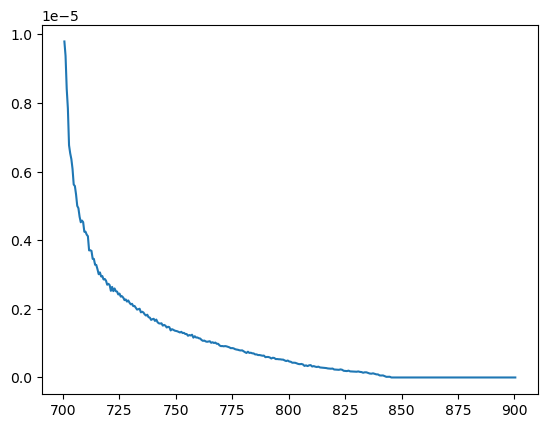

In [32]:
# plt.plot(wl,torch.mean(kern[0,:,200:500,200:500],dim=(1,2)) )
# plt.plot(a)

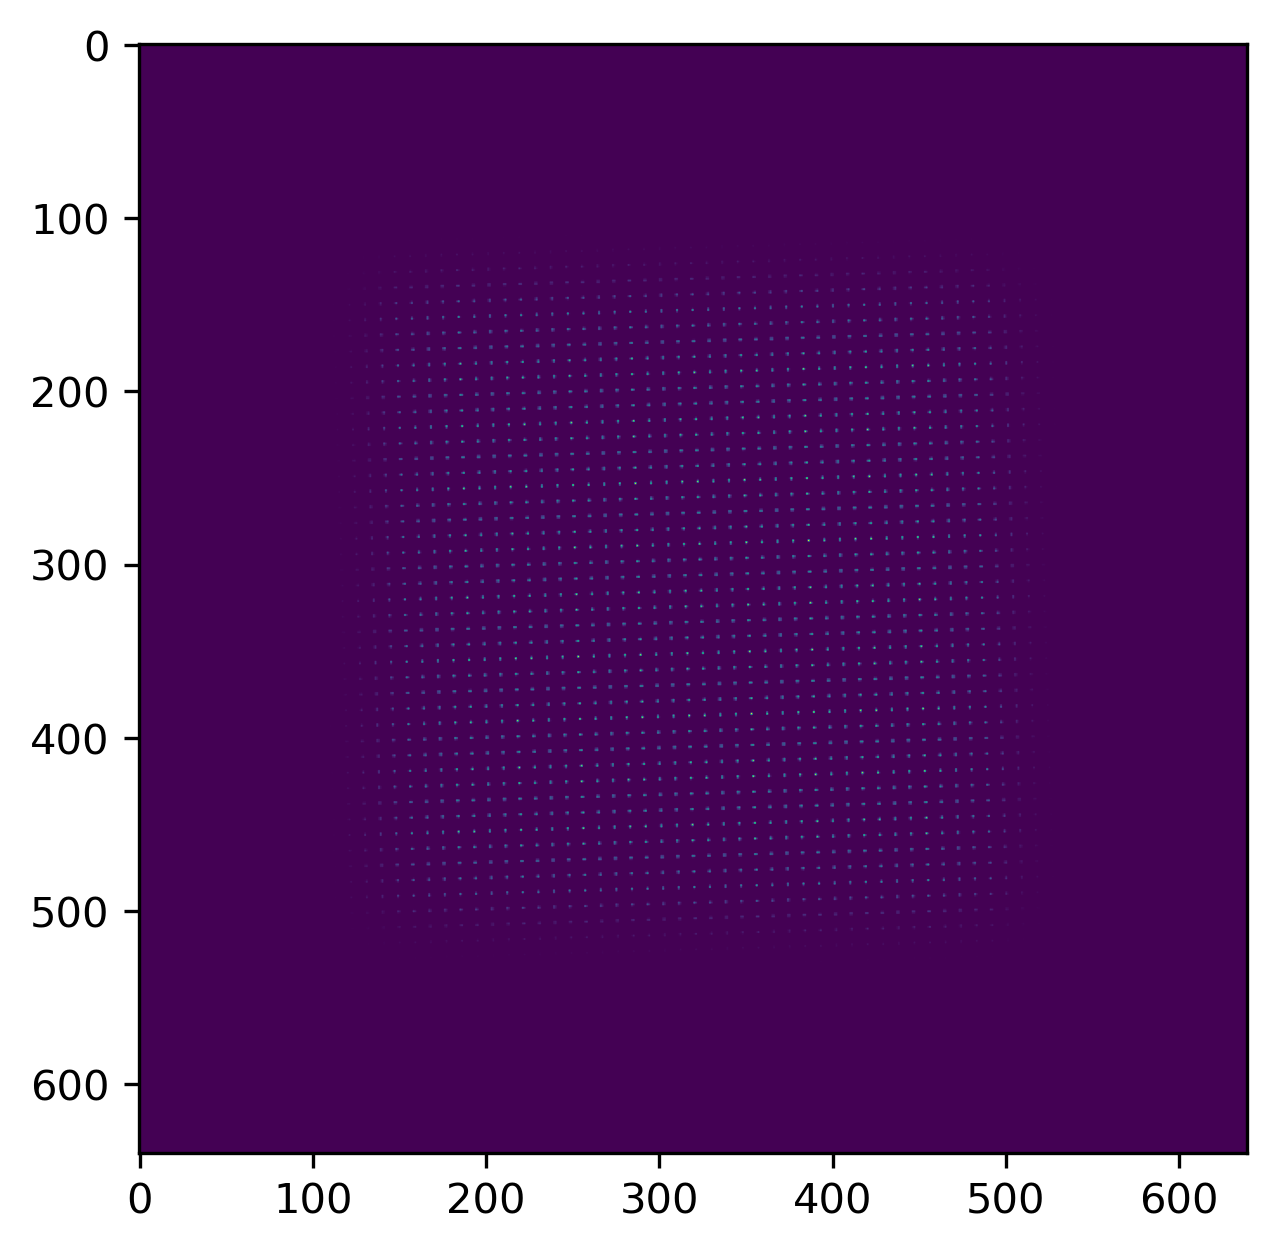

In [272]:
plt.figure(dpi=300)
plt.imshow(generate_cube(nx = 640, rotation=0.03, supergaussian_order= 10)[0,0])

### Can we test the fourier kernel?

In [2]:
kernel = torch.load('../../models/kernel.pt',map_location=device).requires_grad_(False)

fts_dir = '20230708_2gratings_2000us_data'

undisp_cube, mask, spectras = create_bs_data(desired_channels=31,kernel=kernel, fts_dir = fts_dir, cube_dir ='20230708_400us_analysis',  interp_type='average',device=device) #here we'll work with synthetic data. 


collecting the undispersed cube and spectra.


In [4]:
disp = disperser.disperse_all_orders(undisp_cube, kernel, pad=False)
disp_pad = disperser.disperse_all_orders(undisp_cube, kernel, pad=True)

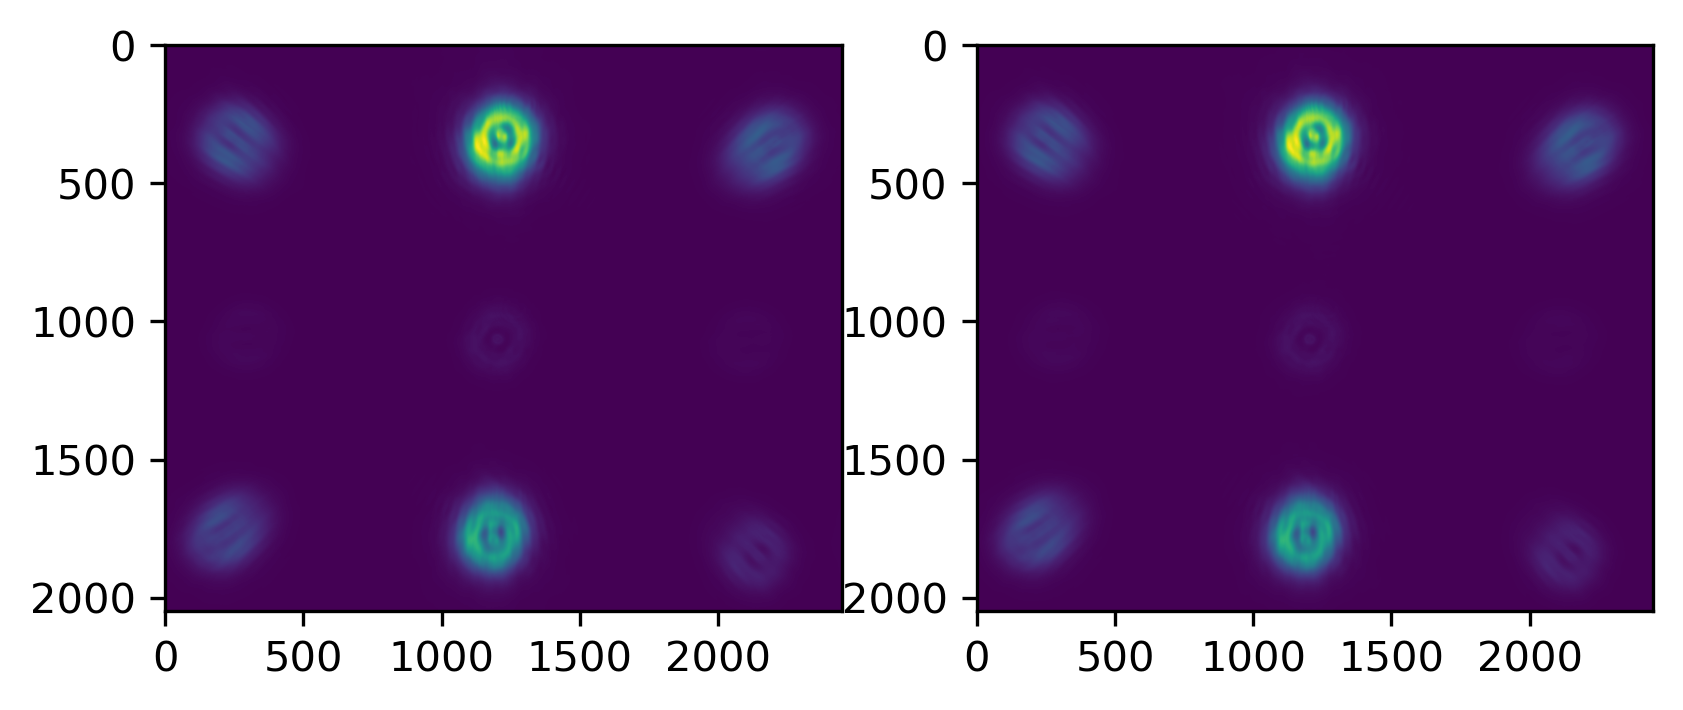

In [5]:
fig,ax = plt.subplots(1,2,dpi=300)
ax[0].imshow(torch.sum(disp.cpu(),dim=(0,1)))
ax[1].imshow(torch.sum(disp_pad.cpu(),dim=(0,1)))

In [10]:
disp_pad.cpu().min(), disp.cpu().min()

(tensor(-2.0005e-07), tensor(0.0040))

In [24]:
from models.helper import FTSDataset

dataset = FTSDataset(undispersed_cube=undisp_cube, spectra = spectras, dir = fts_dir,crop=False)

x,y  = dataset[[0,1]]

Text(0.5, 1.0, 'pred meas')

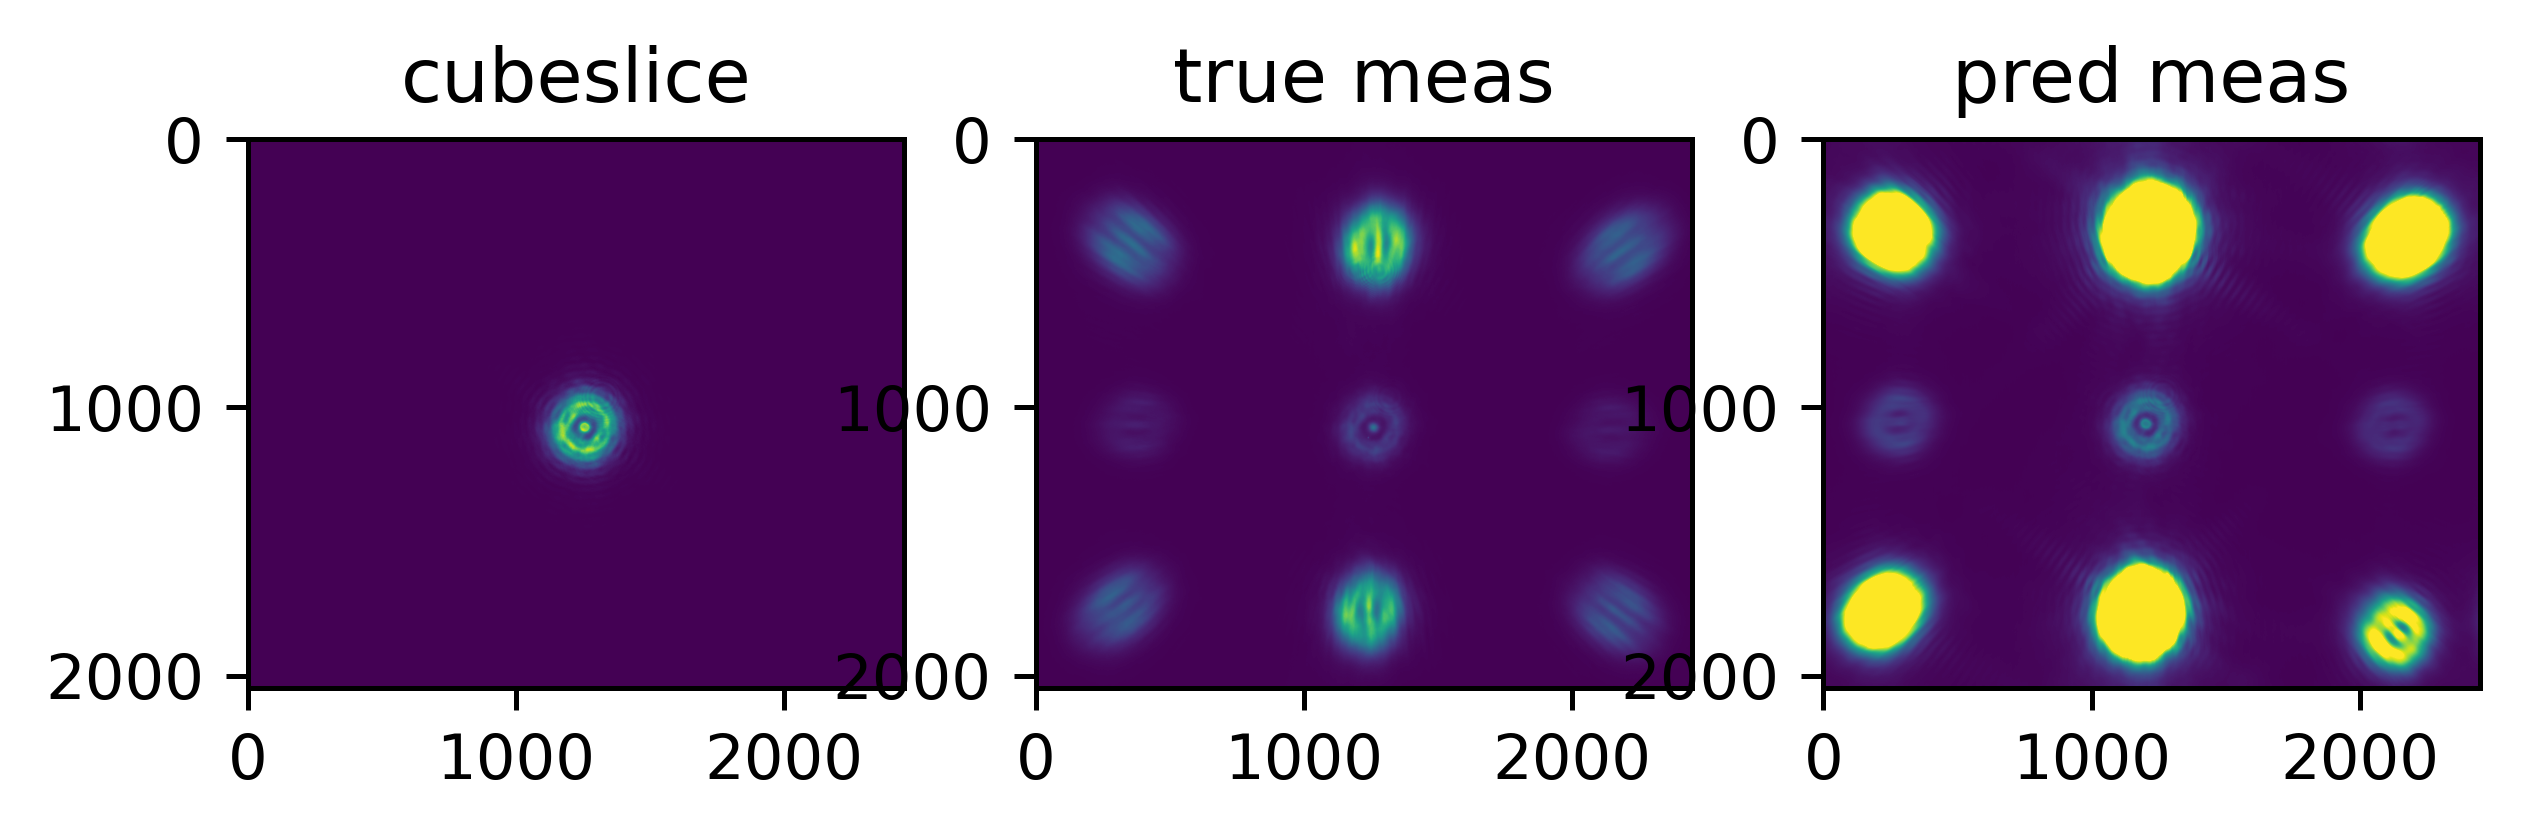

In [26]:
p_dispersed_mask = torch.ones_like(undisp_cube)#!=0
meas = method.calc_psi_z(p_dispersed_mask,y,shift_info = {'kernel':kernel})


fig,ax = plt.subplots(1,3,dpi=450)
ax[0].imshow(y[0,11].cpu().detach()); ax[0].set_title('cubeslice')
ax[1].imshow(x[0].cpu().detach()); ax[1].set_title('true meas')
ax[2].imshow((meas[0].cpu().detach()),vmax = 5); ax[2].set_title('pred meas')


torch.Size([21, 2999])

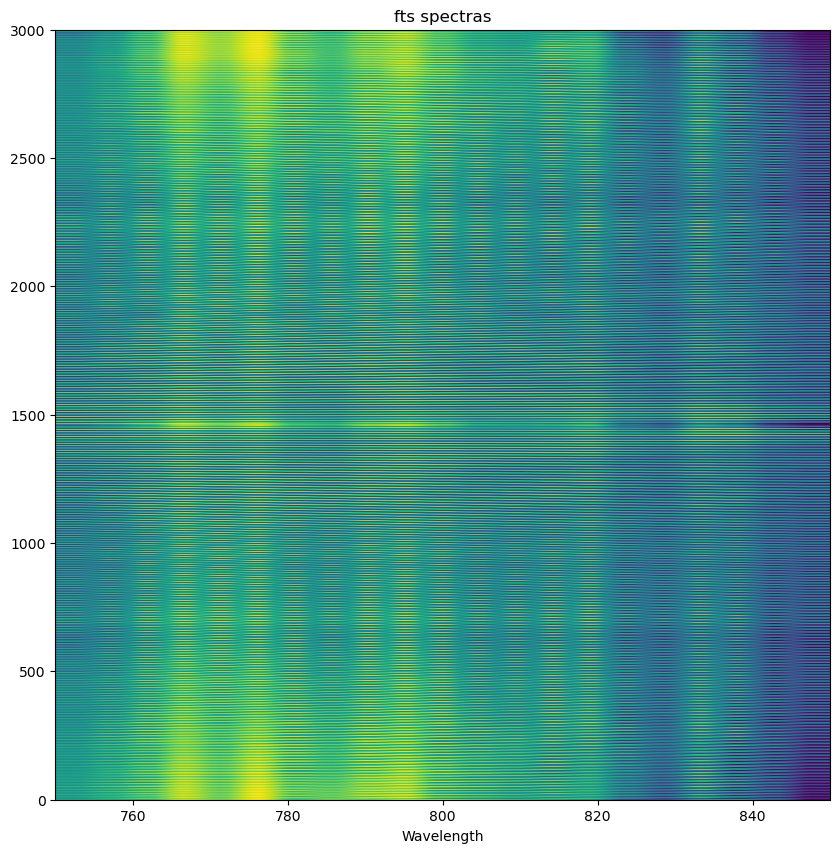

In [119]:
plt.figure(figsize=(10,10))
plt.imshow(spectras.T.cpu().detach(),aspect='auto',extent=[750,850,0,3000])
plt.xlabel('Wavelength')
plt.title('fts spectras')
spectras.shape

## Now load the pinhole data to see how accurate the model is.

In [121]:
fts_dir = '20230628_2gratings_pinhole_data_40000us_talbot_0'

cube, mask, spectras = create_bs_data(desired_channels=21,kernel=kernel, fts_dir = fts_dir, cube_dir ='20230628_pinhole_analysis_800us_talbot_0',  interp_type='average',device='cpu') #here we'll work with synthetic data. 
grating_cube,_,_ = create_bs_data(desired_channels=21,kernel=kernel, fts_dir = fts_dir, cube_dir ='20230628_2gratings_pinhole_analysis_40000us_talbot_0',  interp_type='average',device='cpu') #here we'll work with synthetic data. 

collecting the undispersed cube and spectra.
collecting the undispersed cube and spectra.


In [123]:
from models.helper import FTSDataset, load_cube


kernel = kernel.cpu()
dataset = FTSDataset(undispersed_cube=cube, spectra = spectras.to('cpu'), dir = fts_dir,crop=False)

x,y  = dataset[[0,1]]

Text(0.5, 1.0, 'pred meas')

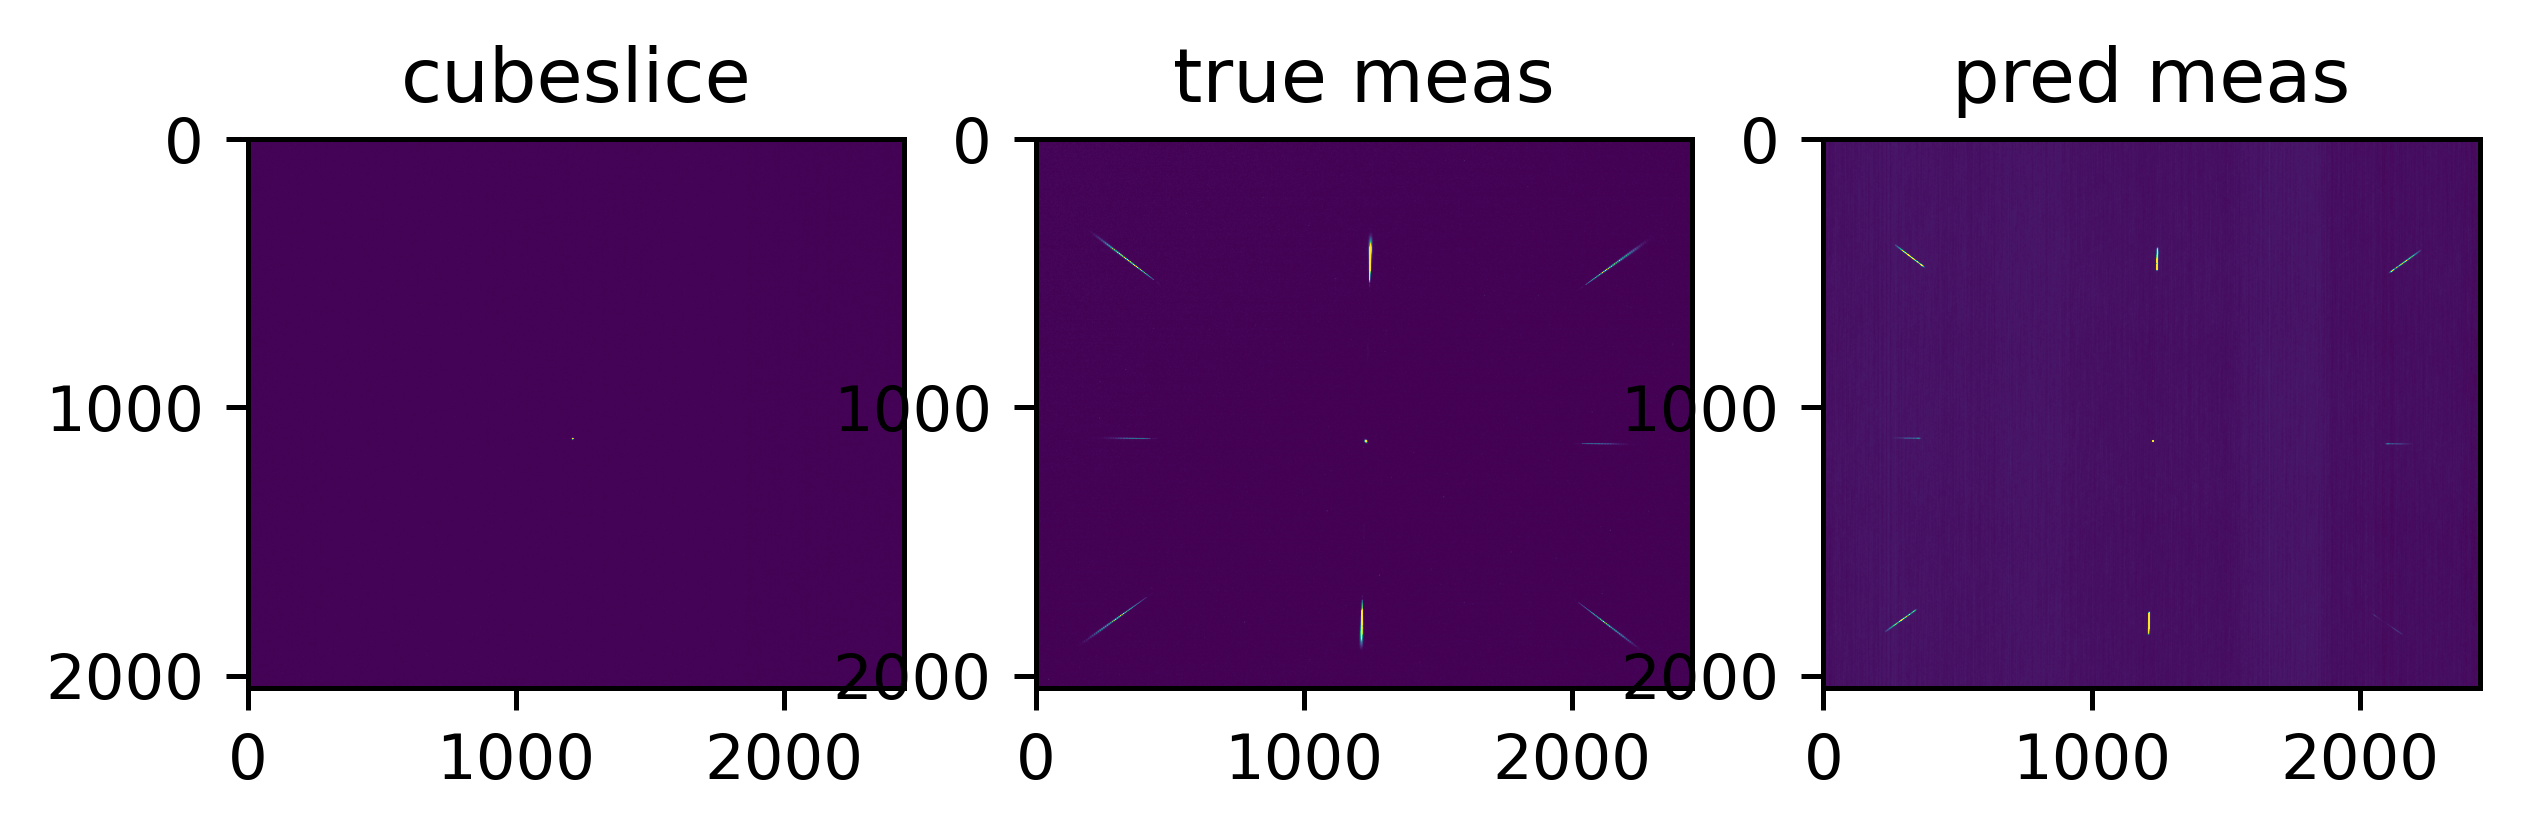

In [124]:
p_dispersed_mask = torch.ones_like(cube)#!=0
meas = torch.abs(method.calc_psi_z(p_dispersed_mask,y,{'kernel':kernel}))
# meas = torch.abs(method.calc_psi_z(torch.ones_like(dispersed_mask),psudoy,shift_info))


fig,ax = plt.subplots(1,3,dpi=450)
ax[0].imshow(y[0,11],vmax=0.01); ax[0].set_title('cubeslice')
ax[1].imshow(x[0],vmax=0.01); ax[1].set_title('true meas')
ax[2].imshow((meas[0]),vmax=0.1); ax[2].set_title('pred meas')

In [125]:
i = [1000,1600]

x,y  = dataset[i]

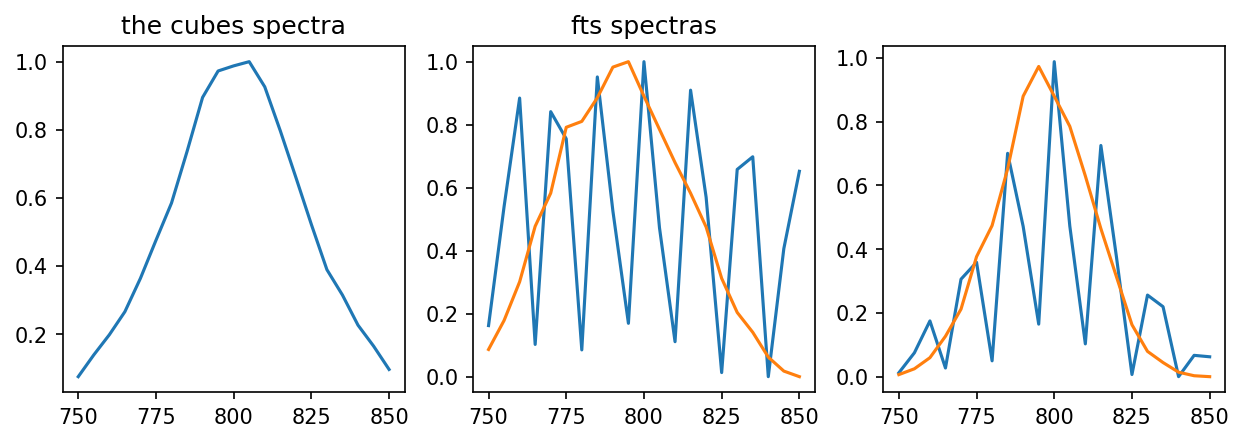

In [126]:
pos = torch.where(cube == torch.max(cube))

fig,ax = plt.subplots(1,3,figsize = (10,3), dpi=150)
ax[0].set_title('the cubes spectra')
ax[0].plot(torch.linspace(750,850,21),cube[0,:,pos[2],pos[3]])
ax[1].plot(torch.linspace(750,850,21),spectras[:,i].cpu()); ax[1].set_title('fts spectras')

ax[2].plot(torch.linspace(750,850,21),y[0,:,pos[2],pos[3]].detach())
ax[2].plot(torch.linspace(750,850,21),y[1,:,pos[2],pos[3]].detach())

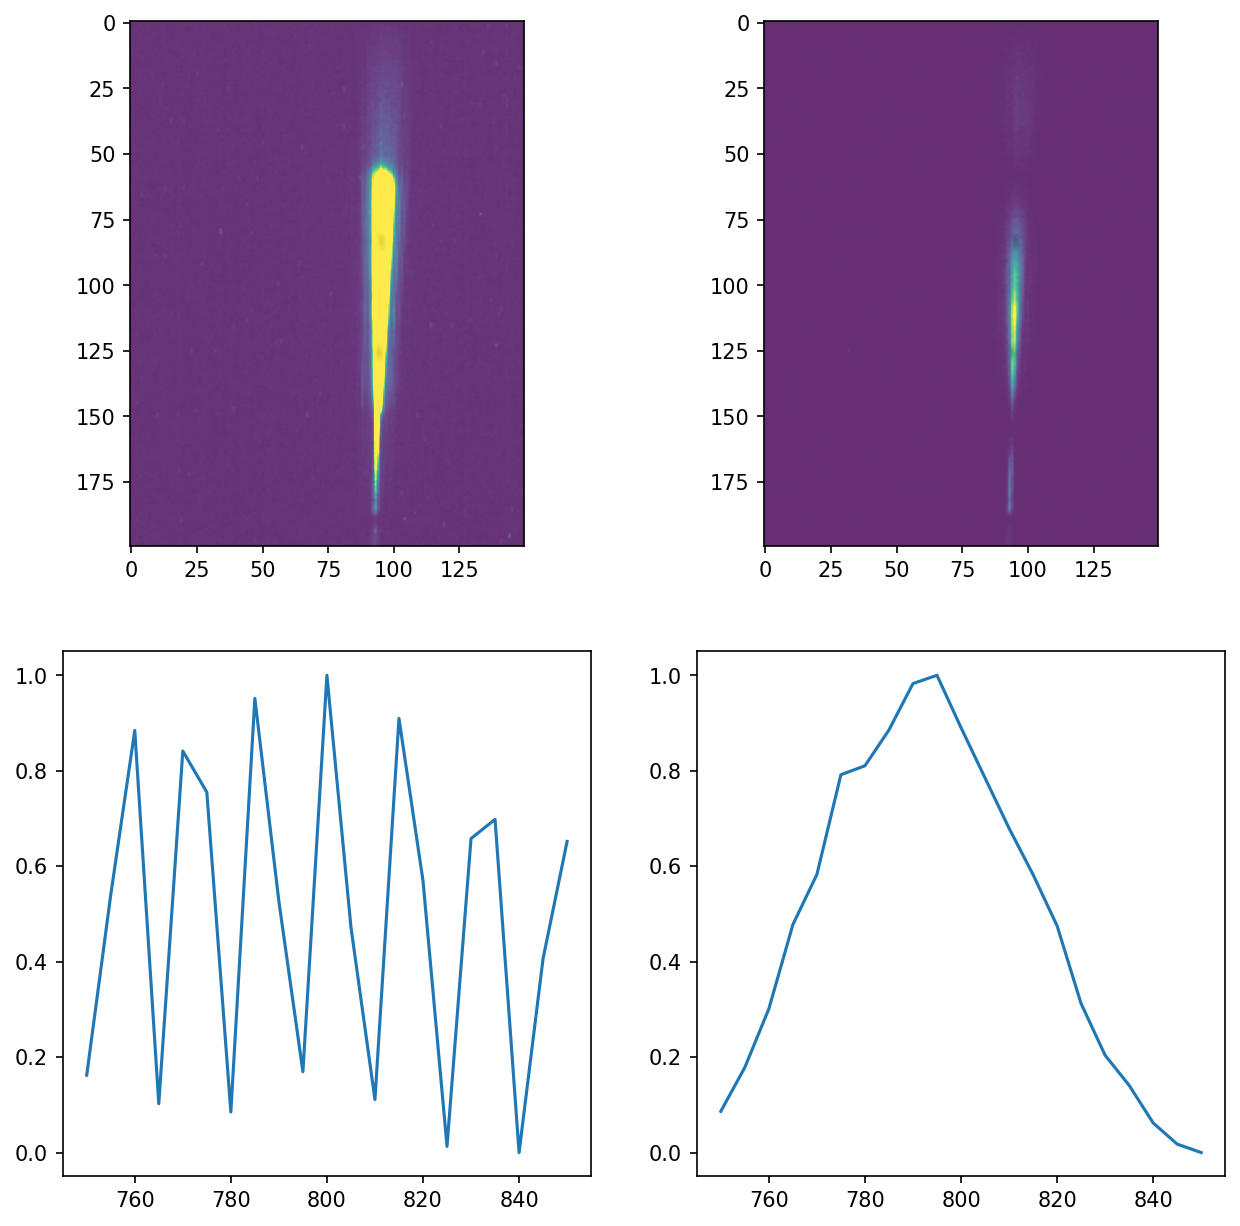

In [127]:
fig,ax = plt.subplots(2,2,figsize = (10,10), dpi=150)

a = (350,550)
b = (1150,1300)

wl = 11
disp_cube = method.disperser.disperse_all_orders(cube,kernel)

# ax[0,0].imshow(x[0,a[0]:a[1],b[0]:b[1]].cpu().detach(),vmax=0.1)
ax[0,0].imshow(torch.sum(grating_cube[0,:,a[0]:a[1],b[0]:b[1]],dim=0).cpu().detach(),vmax=0.1)
ax[0,0].imshow(disp_cube[0,5,a[0]:a[1],b[0]:b[1]].cpu().detach(),cmap='Greys',alpha=0.1)
ax[0,0].imshow(disp_cube[0,15,a[0]:a[1],b[0]:b[1]].cpu().detach(),cmap='Greys',alpha=0.1)
ax[0,1].imshow(x[1,a[0]:a[1],b[0]:b[1]].cpu().detach(),vmax=0.1)
ax[0,1].imshow(disp_cube[0,5,a[0]:a[1],b[0]:b[1]].cpu().detach(),cmap='Greys',alpha=0.1)
ax[0,1].imshow(disp_cube[0,15,a[0]:a[1],b[0]:b[1]].cpu().detach(),cmap='Greys',alpha=0.1)

ax[1,0].plot(torch.linspace(750,850,21),spectras[:,i[0]].cpu())
ax[1,1].plot(torch.linspace(750,850,21),spectras[:,i[1]].cpu())

In [104]:
spectras = (spectras - spectras.min(0)[0]) / (spectras.max(0)[0] - spectras.min(0)[0])

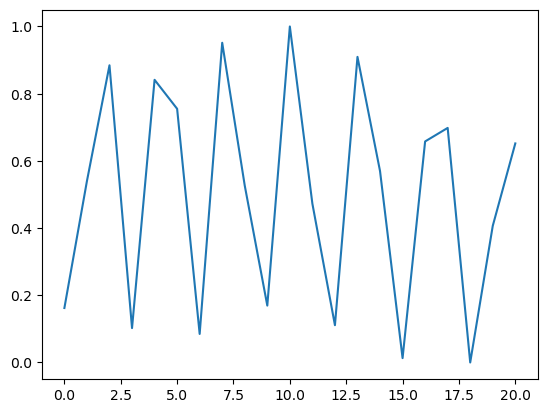

In [106]:
plt.plot(spectras[:,1000])

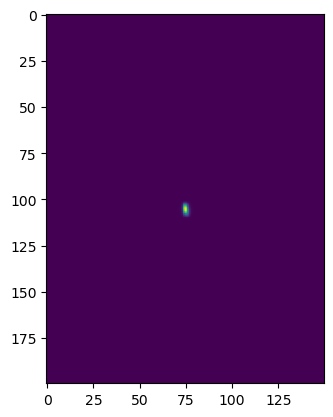

In [83]:
wl = 12
